# FW - ALM

105519.20693409328

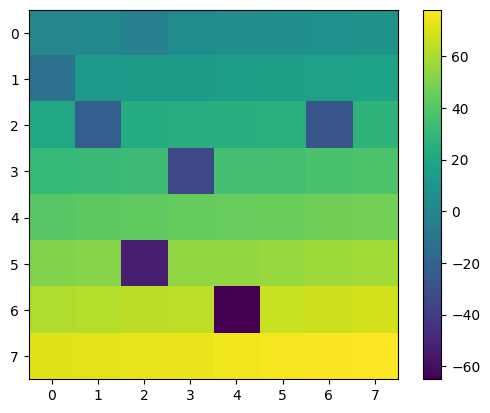

In [1]:
import numpy as np
from scipy.optimize import minimize, linprog
import matplotlib.pyplot as plt
import time

n = 8  # Example problem dimension
M = np.array([
    [1, 2, -3, 4, 5, 6, 7, 8],
    [-11, 12, 13, 14, 15, 16, 17, 18],
    [21, -22, 23, 24, 25, 26, -27, 28],
    [31, 32, 33, -34, 35, 36, 37, 38],
    [41, 42, 43, 44, 45, 46, 47, 48],
    [51, 52, -53, 54, 55, 56, 57, 58],
    [61, 62, 63, 64, -65, 66, 67, 68], 
    [71, 72, 73, 74, 75, 76, 77, 78]
])
b = np.array([ 186,  542,  458 ,1012, 1644, 1686, 1714, 2724])
f, ax = plt.subplots()
m = ax.imshow(M)
cbar = f.colorbar(m)

tolerance = 1e-3

np.linalg.norm(M.T @ M)

C:\Users\Cass\AppData\Local\Temp\ipykernel_9924\1857416585.py:18: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex') # ub
C:\Users\Cass\AppData\Local\Temp\ipykernel_9924\1857416585.py:18: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex') # ub


Iteration 1: X = [9.98707449e-01 4.30636089e+00 2.99061472e+00 3.99103202e+00
 4.98850321e+00 8.92765394e-04 5.10181400e+00 1.35372947e+01], objective = 278.58629360187393, constraints = [ 185.56264172  540.68696404  456.83289063 1009.57274608 1640.11512163
 1682.26215965 1709.91410004 2717.57171534], x_diff = 18.164227828285938, y_diff = 0.0981071883573707
Iteration 2: X = [0.9993908  2.02966672 2.99557654 3.99577323 4.99458135 5.91382342
 6.96690554 8.06432393], objective = 203.54825509088832, constraints = [ 185.79386504  541.38114212  457.44991999 1010.85599079 1642.16898571
 1684.23828742 1712.07424055 2720.97023176], x_diff = 8.577770436206329, y_diff = 0.04623971389188773
Iteration 3: X = [0.99939189 2.02602294 2.99558449 3.99578082 4.99459108 5.9232869
 6.96989057 8.0555646 ], objective = 203.54610704549796, constraints = [ 185.7942351   541.38225313  457.45090753 1010.85804459 1642.17227286
 1684.24145015 1712.07769779 2720.97567099], x_diff = 0.013728474085059205, y_diff = 0.

Converged after 8858 iterations
Elapsed time: 119.24301719665527 seconds, FW average step:  9.406299390381577
[ 185.99987844  541.99963507  457.99967562 1011.99932539 1643.99892027
 1685.99896114 1713.9988644  2723.99821338]


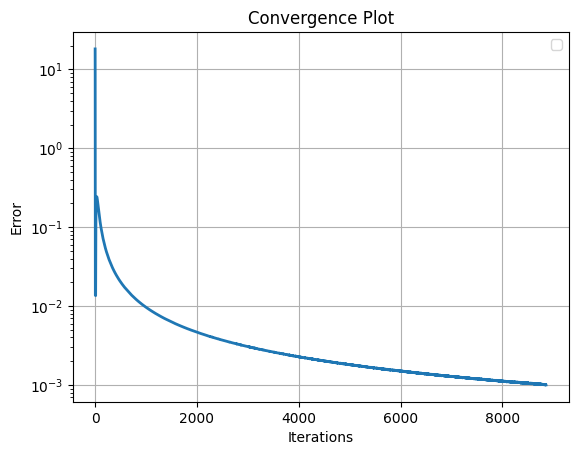

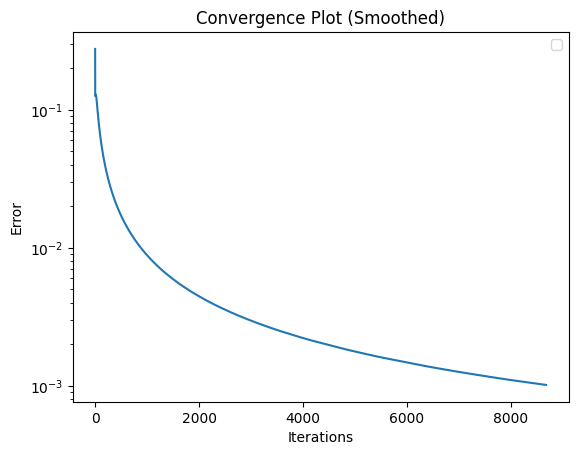

In [40]:
# Define the quadratic function f(x) to be minimized and its gradient
def f(x):
    return np.dot(x.T, x)

def grad_f(x):
    return 2*x

# The augmented Lagrangian function and its gradient
def L(x, y, lam):
    return f(x) + np.dot(y, np.dot(M, x) - b) + (lam / 2) * np.linalg.norm(np.dot(M, x) - b)**2

def grad_L(x, y, lam):
    return grad_f(x) + np.dot(M.T, y) + lam * np.dot(M.T, (np.dot(M, x) - b))

# Frank-Wolfe update step (one step)
def FW_step(x, y, lam, grad_L):
    # Linear minimization oracle
    lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex') # ub
    s = lmo.x
    step = lmo.nit
    # s = linprog(c=grad_L).x
    # Determine step size gamma
    gamma_opt = minimize(lambda g: L(x + g * (s - x), y, lam), 0, bounds=[(0, 1)])
    gamma = gamma_opt.x
    # print(gamma)
    # Update x
    # x_new = x + gamma * (s - x)
    x_new = (1 - gamma) * x + gamma * s
    return x_new, step + gamma_opt.nit

# FW Augmented Lagrangian method (FW-AL)
def FW_AL(x0, y0, lam, eta, max_iter=1000000000, tol=tolerance):
    x, y = x0.copy(), y0.copy()  # Create copies to avoid modifying the original inputs
    x_diff_history = []
    x_history = []
    FW_steps = []

    for t in range(1, max_iter + 1):
        x_prev, y_prev = x.copy(), y.copy()  # Store previous values for convergence check
        # Lagragian = L(x, y, lam)
        grad_L_val = grad_L(x, y, lam)
        x, step = FW_step(x, y, lam, grad_L_val)
        y += eta * (np.dot(M, x) - b)

        x_history.append(x)
        FW_steps.append(step)
        
        # Check convergence: if the change in both x and y is less than the tolerance
        # x_diff = np.linalg.norm(x - x_prev)
        x_diff = np.linalg.norm(x - x_prev)#np.sum(np.abs(x - x_prev))
        x_diff_history.append(x_diff)

        y_diff = np.linalg.norm(y - y_prev)
        if x_diff < tol: # and y_diff < tol:
            print(f"Converged after {t} iterations")
            break
        # Optionally, you can print the progress
        print(f"Iteration {t}: X = {x}, objective = {np.dot(x.T, x)}, constraints = {np.dot(M, x)}, x_diff = {x_diff}, y_diff = {y_diff}")

    return x, y, x_diff_history, sum(FW_steps)/len(FW_steps), x_history

# Example initialization
#np.random.seed(888)
x0 = np.random.randn(n) #n
y0 = np.random.randn(n) #n
#x0 = y0 = np.zeros(n)
lam = 0.1  # Regularization parameter lambda
eta = 0.01  # Step size for the dual update

# Run the algorithm
start_time = time.time()
x_star, y_star, x_diff_history, FW_step_average, x_history = FW_AL(x0, y0, lam, eta)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds, FW average step: ", FW_step_average)
print(np.dot(M, x_star))

# contour plot
# x_history = np.array(x_history)

# x_min, x_max = x_history[:, 0].min() - 1, x_history[:, 0].max() + 1
# y_min, y_max = x_history[:, 1].min() - 1, x_history[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(0.75, 1.25, 100), np.linspace(2, 2.25, 100))

# Z = 0.5 * (xx**2 + yy**2)

# plt.figure(figsize=(8, 6))
# contours = plt.contour(xx, yy, Z, levels=50, cmap='viridis')
# plt.clabel(contours, inline=True, fontsize=8)

# plt.plot(x_history[:, 0], x_history[:, 1], 'r.-', label='Path of x')
# plt.scatter(x_history[:, 0], x_history[:, 1], c='red', s=50)

# plt.title('Contour Plot of x_history')
# plt.xlabel('x1')
# plt.ylabel('x2')
# plt.legend()
# plt.show()

# The optimal values will be in x_star and y_star
plt.plot(x_diff_history, lw=2)  # lw is the line width
plt.xlabel('Iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)  # Adds a grid for better readability
plt.show()

def moving_average(data, window_size):
    """Compute the moving average using a simple sliding window algorithm."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example usage after the algorithm has run
smoothed_x_diff_history = moving_average(x_diff_history, window_size=int(round(len(x_diff_history) / 50, 0)))

# Plotting the smoothed data
plt.plot(smoothed_x_diff_history)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Convergence Plot (Smoothed)')
plt.legend()
plt.show()


# FW - BALM (include constrains in s)

C:\Users\Cass\AppData\Local\Temp\ipykernel_10048\3140896006.py:24: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex')
C:\Users\Cass\AppData\Local\Temp\ipykernel_10048\3140896006.py:24: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1.]
Iteration 1: x: [ 1.          0.          3.          4.          5.         11.18518519
  8.62962963  3.18518519], objective = 260.72427983538444, constraints = [ 186.  542.  458. 1012. 1644. 1686. 1714. 2724.], x_diff = 17.519679985859693, y_diff = 0.1314359718522841
[0.44150158]
Iteration 2: x: [1.         1.90476395 3.         4.         5.         6.24690828
 7.07759974 7.77072803], objective = 204.1286209584194, constraints = [ 186.  542.  458. 1012. 1644. 1686. 1714. 2724.], x_diff = 7.172914643687515, y_diff = 2.3783062254581537e-09
[0.03766663]
Iteration 3: x: [1.         1.99552251 3.         4.         5.         6.01160831
 7.00364833 7.98922086], objective = 204.0002843009442, constraints = [ 186.  542.  458. 1012. 1644. 1686. 1714. 2724.], x_diff = 0.34177641619552473, y_diff = 1.8972440171277345e-09
[0.00196264]
Iteration 4: x: [1.         2.0000734  3.         4.         5.         5.9998097
 6.99994019 8.00017671], objective = 204.00000007640386, constraints = [ 1

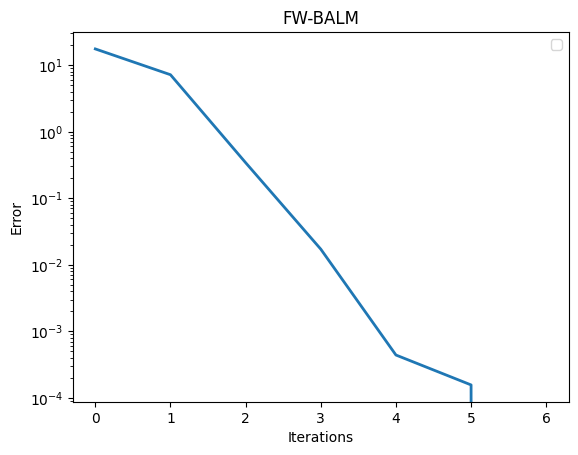

In [4]:
import time
import numpy as np
from scipy.optimize import minimize, linprog
import matplotlib.pyplot as plt

# Define the quadratic function f(x) to be minimized and its gradient
def f(x):
    return np.dot(x.T, x)

def grad_f(x):
    return 2* x

# The augmented Lagrangian function and its gradient
def L(x, y, lam, xk, yk):
    return f(x) + (lam / 2) * np.linalg.norm(x - (xk + (1 / lam) * np.dot(M.T, yk)))**2

def grad_L(x, y, lam, xk, yk):
    return grad_f(x) + lam * (x - xk - (1 / lam) * np.dot(M.T, yk))

# Frank-Wolfe update step (one step)
def FW_step(x, y, lam, grad_L, M, b):
    # Linear minimization oracle
    # s = linprog(c=grad_L, A_ub=M, b_ub=b, method='highs').x
    lmo = linprog(c=grad_L, A_eq=M, b_eq=b, method='simplex')
    s = lmo.x
    # print(lmo.nit)
    # s = linprog(c=grad_L).x
    # Determine step size gamma
    gamma_opt = minimize(lambda g: L(x + g * (s - x), y, lam, x, y), 0.5, bounds=[(0, 1)])
    gamma = gamma_opt.x
    print(gamma)
    # Update x
    # x_new = x + gamma * (s - x)
    x_new = (1 - gamma) * x + gamma * s
    return x_new, lmo.nit + gamma_opt.nit

# Frank-Wolfe (away step)
def away_step_FW(x, y, lam, grad_f, L, M, b, max_iter=1000, tol=1e-6):
    n = len(x)
    S = np.eye(n)  # Initialize the active set to be the vertices of the simplex
    drop_step = True
    iteration = 0

    while drop_step and iteration < max_iter:
        grad_L_val = grad_L(x, y, lam, x, y)

        # LMO - Linear Minimization Oracle
        s = linprog(c=grad_L_val, A_eq=M, b_eq=b, method='highs').x

        # Away step vertex
        v = S[:, np.argmax(np.dot(S.T, grad_L_val))]

        # Compute FW and Away gaps
        g_FW = np.dot(grad_L_val, x - s)
        g_A = np.dot(grad_L_val, x - v)

        # Decide direction (FW direction or Away direction)
        if g_FW >= g_A:
            d = s - x
            gamma_max = 1
        else:
            d = x - v
            alpha_v = np.min(S[:, np.argmax(np.dot(S.T, x))])  # Assuming alpha_v is stored for each vertex in S
            gamma_max = alpha_v / (1 - alpha_v)

        # Compute step size
        gamma = minimize(lambda g: L(x + g * d, y, lam), 0.5, bounds=[(0, gamma_max)]).x

        # Check for drop step
        if gamma < gamma_max:
            drop_step = False

        # Update x
        x = x + gamma * d

        # Update alpha_v and S (active set)
        if g_FW < g_A:  # If away step was taken
            alpha_v = alpha_v - gamma  # Decrease weight of v
            if alpha_v == 0:
                S = S[:, S[0] != v]  # Remove v from the active set if its weight is zero

        # Increment the iteration counter
        iteration += 1

        # Convergence check
        x_diff = np.linalg.norm(gamma * d)
        if x_diff < tol:
            break

    return x, S

# FW Augmented Lagrangian method (FW-AL)
def FW_AL(x0, y0, lam, delta, n, M, b, max_iter=10000000, tol=tolerance):
    x, y = x0.copy(), y0.copy()  # Create copies to avoid modifying the original inputs
    x_diff_history = []
    FW_steps = []

    for t in range(1, max_iter + 1):
        x_prev, y_prev = x.copy(), y.copy()  # Store previous values for convergence check
        # Lagragian = L(x, y, lam)
        grad_L_val = grad_L(x, y, lam, x, y)
        x, step = FW_step(x, y, lam, grad_L_val, M, b)
        # x, S = away_step_FW(x, y, lam, grad_L_val, L, M, b)
        FW_steps.append(step)

        H0 = ((1 / lam) * M @ M.T) + (delta * np.eye(n))
        y -= np.dot(np.linalg.inv(H0), (np.dot(M, 2 * x - x_prev) - b))
        
        # Check convergence: if the change in both x and y is less than the tolerance
        x_diff = np.linalg.norm(x - x_prev)
        #x_diff = np.sum(np.abs(x - x_prev))
        x_diff_history.append(x_diff)

        y_diff = np.linalg.norm(y - y_prev)

        # Optionally, you can print the progress
        print(f"Iteration {t}: x: {x}, objective = {np.dot(x.T, x)}, constraints = {np.dot(M, x)}, x_diff = {x_diff}, y_diff = {y_diff}")

        if x_diff < tol: # and y_diff < tol:
            print(f"Converged after {t} iterations")
            break
        
    return x, y, x_diff_history, sum(FW_steps)/len(FW_steps)

# Example initialization
x0 = np.random.randn(n)
y0 = np.random.randn(n)
lam = 0.1  # Regularization parameter lambda
delta = 1e-4 # Computation for H0

# Run the algorithm
start_time = time.time()
x_star, y_star, x_diff_history, FW_step_average = FW_AL(x0, y0, lam, delta, n, M, b, tol=1e-6)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds, FW average step: ", FW_step_average)
print(np.dot(M, x_star))

# The optimal values will be in x_star and y_star
plt.plot(x_diff_history, lw=2)  # lw is the line width
plt.xlabel('Iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.title('FW-BALM')
plt.legend()
 # Adds a grid for better readability
plt.show()


# BALM

iteration 0: [-1352.20791449 -1268.03143005  -676.55123274  -840.61680174
  -253.55176883 -1513.90494834 -1380.12472398 -1573.2741218 ], objective: 11336860.537618116
[ -37819.33885972 -100712.70155695  -88723.78707808 -250464.59199652
 -396209.16393447 -413077.36268399 -540412.69282601 -661957.05219322]
iteration 1: [-122.01894928 -113.80713584  -58.77745731  -72.78338248  -18.50474263
 -131.26708631 -118.81736175 -136.59370745], objective: 86941.7782208919
[ -3269.03180182  -8662.977892    -7649.44149545 -21849.52122866
 -34524.48946757 -36019.77722317 -47570.26938674 -57701.584159  ]
iteration 2: [-10.18353485  -8.84563526  -2.61611896  -2.98030839   2.86320357
  -5.6549647   -4.17905985  -5.90987154], objective: 290.2436450261587
[ -128.09384365  -294.81569043  -279.03917361 -1066.31828626
 -1644.04215641 -1741.79644645 -2766.38442057 -2769.23085566]
iteration 3: [-0.01668409  0.7251618   2.4894453   3.36542677  4.80574597  5.68939917
  6.21909949  6.04002353], objective: 148.67311

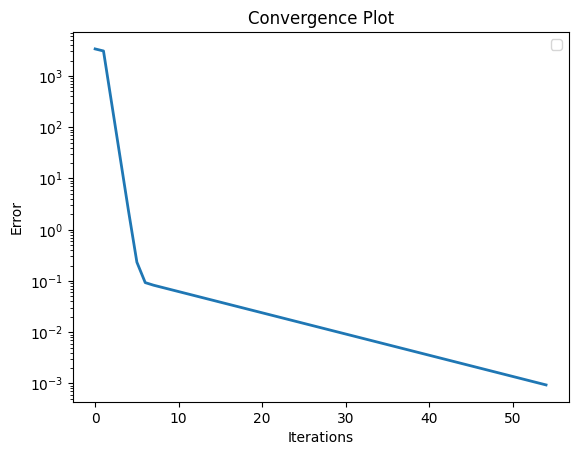

In [24]:
import numpy as np
import pyproximal
import pylops
import matplotlib.pyplot as plt
import time

def x_step_prox(q0k):
    quad = pyproximal.Quadratic(Op=pylops.MatrixMult(np.identity(H0.shape[0])))
    xk1 = pyproximal.optimization.primal.ProximalPoint(quad, q0k, r, show=False, niter=1)
    return xk1

def x_step_FW():
    pass

def BALM(A, b, r, x0, lambda0):
    improvement = []
    xk = x0
    lambdak = lambda0
    
    for i in range(1000):
        q0k = xk + (1/r) * A.T @ lambdak

        # x step
        xk1 = x_step_prox(q0k)
        
        # lambda step
        s0k = A @ (2*xk1 - xk) - b
        lambdak1 = lambdak - H0_inv @ s0k
        
        # update
        #error = np.sum(np.abs(xk - xk1))
        error = np.linalg.norm(xk - xk1)
        improvement.append(error)
        if error < 1e-3:
            return xk1, improvement
        xk = xk1
        lambdak = lambdak1
        print(f"iteration {i}: {xk}, objective: {np.dot(xk.T, xk)}")
        print(A@xk)
        
    return xk, improvement

# A = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
# b = np.array([1, 2, 3])
A = np.array([[1, 2],
              [-1, 4]])
#b = np.array([-5, -7]) # 3, 1, -2
A = M
r = 0.1
delta = 0.001 
H0 = 1/r * A @ A.T
H0 = H0 + delta * np.identity(H0.shape[0])
H0_inv = np.linalg.inv(H0)
# x0 = np.array([1,1,1])
# lambda0 = np.array([1,1,1])
x0 = np.random.randn(n)
y0 = np.random.randn(n)

start_time = time.time()
xk, improvement = BALM(M,b,r,x0,y0)
end_time = time.time()
elapsed_time = end_time - start_time

plt.plot(improvement, lw=2)  # lw is the line width
plt.xlabel('Iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.title('Convergence Plot')
plt.legend()

print("Elapsed time:", elapsed_time, "seconds")
print(A@xk)

# Just for generate solvable Ax = b for testing

In [ ]:
import numpy as np

# Define the dimensions
d = 2

# Generate a random matrix A of size dxd
# A = np.array([[1, 2, 3, 4, 5],
#               [-1, 4, 5, 7, 8],
#               [4, 6, 2, 6, 7],
#               [6, 8, 2, -7, 2],
#               [5, 7, -9, 4, 1]])

A = np.array([
    [1, 2, -3, 4, 5, 6, 7],
    [-11, 12, 13, 14, 15, 16, 17],
    [21, -22, 23, 24, 25, 26, -27],
    [31, 32, 33, -34, 35, 36, 37],
    [41, 42, 43, 44, 45, 46, 47],
    [51, 52, -53, 54, 55, 56, 57],
    [61, 62, 63, 64, -65, 66, 67]
])

# Generate a random vector b of size d
x = np.array([1, 2, 3, 4, 5, 6, 7])

# Solve the linear system Ax = b
b = np.dot(A, x)

print("Matrix A:")
print(A)
print("\nVector b:")
print(b)
print("\nSolution x:")
print(x)


Matrix A:
[[  1   2  -3   4   5   6   7]
 [-11  12  13  14  15  16  17]
 [ 21 -22  23  24  25  26 -27]
 [ 31  32  33 -34  35  36  37]
 [ 41  42  43  44  45  46  47]
 [ 51  52 -53  54  55  56  57]
 [ 61  62  63  64 -65  66  67]]

Vector b:
[ 122  398  234  708 1260 1222 1170]

Solution x:
[1 2 3 4 5 6 7]


In [ ]:
import numpy as np

# Create a random plane
normal_vector1 = np.random.rand(3)
d1 = np.random.rand(1)

# Create another plane that is not parallel to the first
# This can be ensured by not making the normal vectors scalar multiples of each other
normal_vector2 = np.random.rand(3)
while np.allclose(normal_vector2 / np.linalg.norm(normal_vector2), normal_vector1 / np.linalg.norm(normal_vector1)):
    normal_vector2 = np.random.rand(3)  # Generate a different normal vector

d2 = np.random.rand(1)

# Plane equations are now:
# normal_vector1[0]*x + normal_vector1[1]*y + normal_vector1[2]*z = d1
# normal_vector2[0]*x + normal_vector2[1]*y + normal_vector2[2]*z = d2

# Convert these to matrix form, Ax = b
A = np.array([normal_vector1, normal_vector2])
b = np.array([d1, d2]).flatten()

# Now A and b represent two plane equations that intersect along a line
print("Plane 1 coefficients:", normal_vector1, "= d1:", d1)
print("Plane 2 coefficients:", normal_vector2, "= d2:", d2)
print("Matrix A:\n", A)
print("Vector b:", b)


Plane 1 coefficients: [0.8994776  0.24836496 0.03017182] = d1: [0.07244715]
Plane 2 coefficients: [0.87416449 0.55843035 0.91604736] = d2: [0.63346045]
Matrix A:
 [[0.8994776  0.24836496 0.03017182]
 [0.87416449 0.55843035 0.91604736]]
Vector b: [0.07244715 0.63346045]
